In [6]:
%load_ext autoreload
%autoreload 2

import os
import time

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from torchvision import transforms


from datasets import BadNetsDataset, WaNetDataset
from simclr import SimClrBackbone

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
device = "cuda"
epochs = 300
batch_size = 128

## Poison dataset

In [8]:
dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=True, download=True)
#poison_dataset = BadNetsDataset(dataset, 0, "triggers/trigger_white.png", seed=1)
#poison_dataset = WaNetDataset(dataset, 0, seed=1)
poison_dataset = BadNetsDataset(dataset, 1, "triggers/trigger_10.png", seed=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## SimCLR data augmentations

In [10]:
class ConstrastiveDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, s: int = 0.5):
        self.original_dataset = original_dataset

        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomResizedCrop(32,(0.8,1.0),antialias=False),
            transforms.Compose([transforms.RandomApply([
                transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                transforms.RandomGrayscale(p=0.2)]),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
            ])
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, index):
        img = self.original_dataset[index][0]
        augmented_img_1 = self.transforms(img)
        augmented_img_2 = self.transforms(img)
        return augmented_img_1, augmented_img_2
    
constrastive_dataset = ConstrastiveDataset(poison_dataset)

## SimCLR model

In [11]:
model = SimClrBackbone()
model = model.to(device)

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## LARS optimizer

In [12]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

## SimCLR contrastive loss

In [13]:
class SimCLR_Loss(nn.Module):
    def __init__(self, temperature):
        super(SimCLR_Loss, self).__init__()
        self.temperature = temperature

        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
            
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        batch_size = z_i.shape[0]
        mask = self.mask_correlated_samples(batch_size)

        N = 2 * batch_size #* self.world_size
        
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        #print(sim.shape)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, batch_size)
        
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)
        
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

## Training

In [14]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = False)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = False)

criterion = SimCLR_Loss(temperature=0.5)

dataloader = DataLoader(constrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_no_contrastive = DataLoader(poison_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

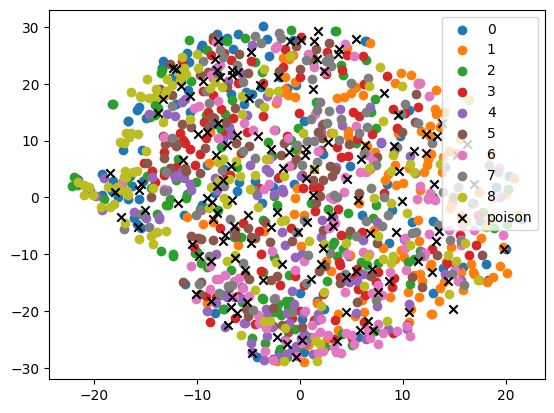

In [15]:
from sklearn.manifold import TSNE

def plot_features(model: nn.Module, dataloader: DataLoader, batches: int = None):
    model.eval()

    features = None
    labels_poison = None
    labels_true = None

    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        if batches is not None and i>=batches:
            break
    
        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        if features is None:
            features = features_batch
            labels_poison = labels_batch_poison
            labels_true = labels_batch_true
        else:
            features = np.append(features, features_batch, axis=0)
            labels_poison = np.append(labels_poison, labels_batch_poison, axis=0)
            labels_true = np.append(labels_true, labels_batch_true, axis=0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features)
    num_classes = max(labels_batch_poison)

    labels = labels_true
    labels[labels_true != labels_poison] = 10

    for i in range(num_classes):
        plt.scatter(tsne_features[labels==i,1], tsne_features[labels==i,0])
    plt.scatter(tsne_features[labels==10,1], tsne_features[labels==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()

    model.train()

plot_features(model, dataloader_no_contrastive, 10)

In [16]:
def train(dataloader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dataloader):
        optimizer.zero_grad()
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if step % 50 == 0:
            print(f"\tStep [{step}/{len(dataloader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch / len(dataloader)

In [17]:
def save_model(model, optimizer, scheduler, epoch, name):
    out = os.path.join('./saved_models/', name)

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch
                }, out)

    print(f"\tSaved model, optimizer, scheduler and epoch info to {out}")

In [19]:
start_epoch = 0

load_checkpoint = False
checkpoint_name = "WaNet-SimCLR_150.pt"

if load_checkpoint:
    out = os.path.join('./saved_models/', checkpoint_name)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    mainscheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1

Epoch [0/300]	


C:\Users\Luka\AppData\Local\Temp\ipykernel_12700\1065139194.py:129: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1519.)
  next_v.mul_(momentum).add_(scaled_lr, grad)


	Step [0/391]	 Loss: 5.2809
	Step [50/391]	 Loss: 4.44857
	Step [100/391]	 Loss: 4.02327
	Step [150/391]	 Loss: 3.94057
	Step [200/391]	 Loss: 3.88306
	Step [250/391]	 Loss: 3.82161
	Step [300/391]	 Loss: 3.79342
	Step [350/391]	 Loss: 3.78058

	Training Loss: 4.026115115646206
	Time Taken: 3.864912474155426 minutes
	Saved model, optimizer, scheduler and epoch info to ./saved_models/SimCLR_0.pt


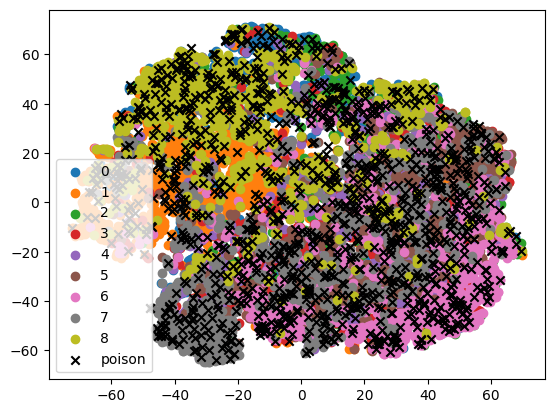

Epoch [1/300]	
	Step [0/391]	 Loss: 3.78131
	Step [50/391]	 Loss: 3.75699
	Step [100/391]	 Loss: 3.76935
	Step [150/391]	 Loss: 3.77003
	Step [200/391]	 Loss: 3.75545
	Step [250/391]	 Loss: 3.76257
	Step [300/391]	 Loss: 3.74995
	Step [350/391]	 Loss: 3.76097

	Training Loss: 3.761991538659996
	Time Taken: 3.863959542910258 minutes
Epoch [2/300]	
	Step [0/391]	 Loss: 3.75295
	Step [50/391]	 Loss: 3.76397
	Step [100/391]	 Loss: 3.74333
	Step [150/391]	 Loss: 3.7341
	Step [200/391]	 Loss: 3.74383
	Step [250/391]	 Loss: 3.74923
	Step [300/391]	 Loss: 3.74316
	Step [350/391]	 Loss: 3.73921

	Training Loss: 3.7444631742394487
	Time Taken: 3.846695653597514 minutes
Epoch [3/300]	
	Step [0/391]	 Loss: 3.72941
	Step [50/391]	 Loss: 3.72971
	Step [100/391]	 Loss: 3.72576
	Step [150/391]	 Loss: 3.71109
	Step [200/391]	 Loss: 3.7294
	Step [250/391]	 Loss: 3.71631
	Step [300/391]	 Loss: 3.73646
	Step [350/391]	 Loss: 3.72579

	Training Loss: 3.728759635135036
	Time Taken: 3.8512911001841226 minute

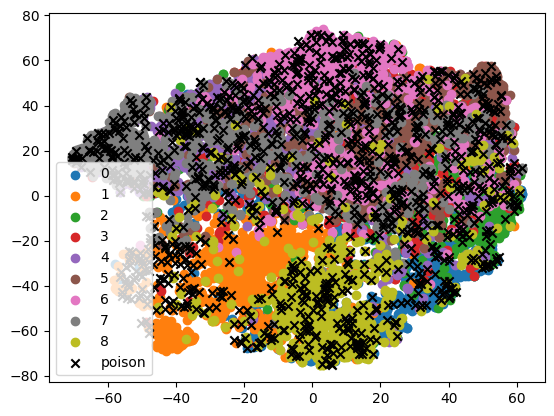

Epoch [11/300]	
	Step [0/391]	 Loss: 3.67085
	Step [50/391]	 Loss: 3.67291
	Step [100/391]	 Loss: 3.65983
	Step [150/391]	 Loss: 3.66497
	Step [200/391]	 Loss: 3.67297
	Step [250/391]	 Loss: 3.67814
	Step [300/391]	 Loss: 3.67253
	Step [350/391]	 Loss: 3.66576

	Training Loss: 3.6660272544607175
	Time Taken: 3.840722636381785 minutes
Epoch [12/300]	
	Step [0/391]	 Loss: 3.6592
	Step [50/391]	 Loss: 3.67266
	Step [100/391]	 Loss: 3.66082
	Step [150/391]	 Loss: 3.66756
	Step [200/391]	 Loss: 3.66089
	Step [250/391]	 Loss: 3.67067
	Step [300/391]	 Loss: 3.65415
	Step [350/391]	 Loss: 3.65477

	Training Loss: 3.661609890515847
	Time Taken: 3.8468929330507913 minutes
Epoch [13/300]	
	Step [0/391]	 Loss: 3.65162
	Step [50/391]	 Loss: 3.65677
	Step [100/391]	 Loss: 3.65373
	Step [150/391]	 Loss: 3.66496
	Step [200/391]	 Loss: 3.65866
	Step [250/391]	 Loss: 3.66534
	Step [300/391]	 Loss: 3.65691
	Step [350/391]	 Loss: 3.65309

	Training Loss: 3.657799645762919
	Time Taken: 3.8504762490590414 m

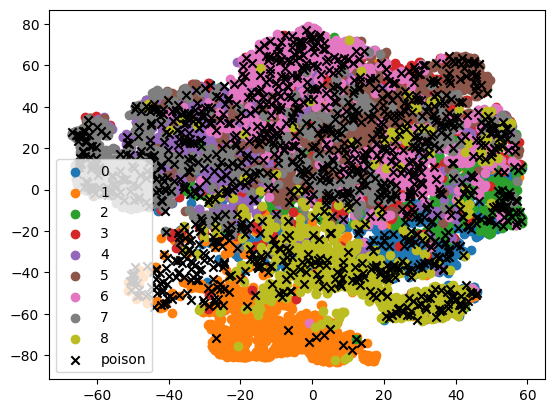

Epoch [21/300]	
	Step [0/391]	 Loss: 3.63929
	Step [50/391]	 Loss: 3.64426
	Step [100/391]	 Loss: 3.63705
	Step [150/391]	 Loss: 3.63889
	Step [200/391]	 Loss: 3.64504
	Step [250/391]	 Loss: 3.63513
	Step [300/391]	 Loss: 3.63213
	Step [350/391]	 Loss: 3.63639

	Training Loss: 3.6412650514441682
	Time Taken: 3.8564687093098957 minutes
Epoch [22/300]	
	Step [0/391]	 Loss: 3.63267
	Step [50/391]	 Loss: 3.63297
	Step [100/391]	 Loss: 3.64517
	Step [150/391]	 Loss: 3.64125
	Step [200/391]	 Loss: 3.64089
	Step [250/391]	 Loss: 3.65292
	Step [300/391]	 Loss: 3.6379
	Step [350/391]	 Loss: 3.64377

	Training Loss: 3.640696660941824
	Time Taken: 3.8543187975883484 minutes
Epoch [23/300]	
	Step [0/391]	 Loss: 3.63573
	Step [50/391]	 Loss: 3.63598
	Step [100/391]	 Loss: 3.63911
	Step [150/391]	 Loss: 3.63164
	Step [200/391]	 Loss: 3.63847
	Step [250/391]	 Loss: 3.64453
	Step [300/391]	 Loss: 3.63549
	Step [350/391]	 Loss: 3.64106

	Training Loss: 3.6391390577301648
	Time Taken: 3.8568854093551637

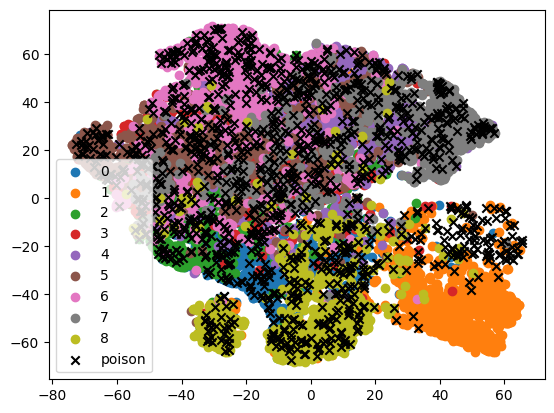

Epoch [31/300]	
	Step [0/391]	 Loss: 3.63401
	Step [50/391]	 Loss: 3.63597
	Step [100/391]	 Loss: 3.62989
	Step [150/391]	 Loss: 3.62805
	Step [200/391]	 Loss: 3.64336
	Step [250/391]	 Loss: 3.62484
	Step [300/391]	 Loss: 3.62871
	Step [350/391]	 Loss: 3.63028

	Training Loss: 3.6311227635044574
	Time Taken: 3.8565400362014772 minutes
Epoch [32/300]	
	Step [0/391]	 Loss: 3.63211
	Step [50/391]	 Loss: 3.63274
	Step [100/391]	 Loss: 3.63035
	Step [150/391]	 Loss: 3.63641
	Step [200/391]	 Loss: 3.62332
	Step [250/391]	 Loss: 3.63124
	Step [300/391]	 Loss: 3.62609
	Step [350/391]	 Loss: 3.63068

	Training Loss: 3.6301018771003273
	Time Taken: 3.849706768989563 minutes
Epoch [33/300]	
	Step [0/391]	 Loss: 3.63439
	Step [50/391]	 Loss: 3.63156
	Step [100/391]	 Loss: 3.63237
	Step [150/391]	 Loss: 3.62943
	Step [200/391]	 Loss: 3.62795
	Step [250/391]	 Loss: 3.62488
	Step [300/391]	 Loss: 3.62095
	Step [350/391]	 Loss: 3.63358

	Training Loss: 3.6295706524568447
	Time Taken: 3.858041397730509

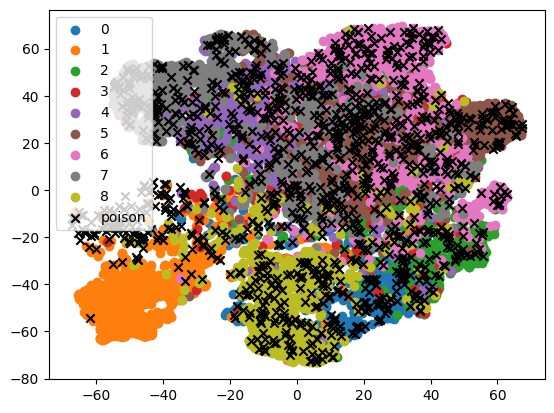

Epoch [41/300]	
	Step [0/391]	 Loss: 3.63405
	Step [50/391]	 Loss: 3.61972
	Step [100/391]	 Loss: 3.62188
	Step [150/391]	 Loss: 3.62597
	Step [200/391]	 Loss: 3.62367
	Step [250/391]	 Loss: 3.62527
	Step [300/391]	 Loss: 3.62819
	Step [350/391]	 Loss: 3.61758

	Training Loss: 3.6243575052227204
	Time Taken: 3.857892370223999 minutes
Epoch [42/300]	
	Step [0/391]	 Loss: 3.63431
	Step [50/391]	 Loss: 3.62694
	Step [100/391]	 Loss: 3.62641
	Step [150/391]	 Loss: 3.6146
	Step [200/391]	 Loss: 3.62724
	Step [250/391]	 Loss: 3.61939
	Step [300/391]	 Loss: 3.61989
	Step [350/391]	 Loss: 3.62538

	Training Loss: 3.6235127424644995
	Time Taken: 3.8545435468355813 minutes
Epoch [43/300]	
	Step [0/391]	 Loss: 3.61942
	Step [50/391]	 Loss: 3.62277
	Step [100/391]	 Loss: 3.62671
	Step [150/391]	 Loss: 3.62181
	Step [200/391]	 Loss: 3.62537
	Step [250/391]	 Loss: 3.62564
	Step [300/391]	 Loss: 3.6165
	Step [350/391]	 Loss: 3.62065

	Training Loss: 3.6230677113203744
	Time Taken: 3.8450602928797406 

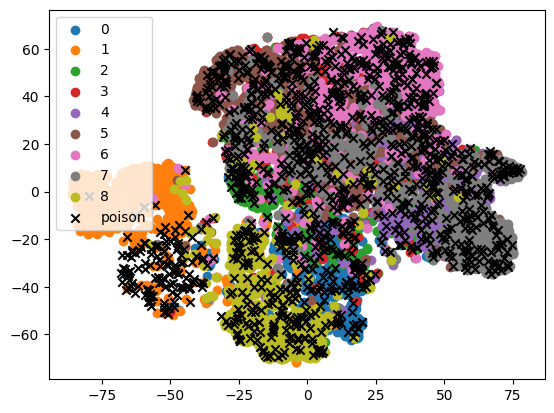

Epoch [51/300]	
	Step [0/391]	 Loss: 3.627
	Step [50/391]	 Loss: 3.61339
	Step [100/391]	 Loss: 3.63268
	Step [150/391]	 Loss: 3.61866
	Step [200/391]	 Loss: 3.62402
	Step [250/391]	 Loss: 3.62322
	Step [300/391]	 Loss: 3.61863
	Step [350/391]	 Loss: 3.62069

	Training Loss: 3.6194083745522265
	Time Taken: 3.8571271498998008 minutes
Epoch [52/300]	
	Step [0/391]	 Loss: 3.61916
	Step [50/391]	 Loss: 3.61941
	Step [100/391]	 Loss: 3.61439
	Step [150/391]	 Loss: 3.62634
	Step [200/391]	 Loss: 3.61917
	Step [250/391]	 Loss: 3.62654
	Step [300/391]	 Loss: 3.62655
	Step [350/391]	 Loss: 3.61405

	Training Loss: 3.618685068681722
	Time Taken: 3.8564109206199646 minutes
Epoch [53/300]	
	Step [0/391]	 Loss: 3.62146
	Step [50/391]	 Loss: 3.62547
	Step [100/391]	 Loss: 3.62567
	Step [150/391]	 Loss: 3.62645
	Step [200/391]	 Loss: 3.62472
	Step [250/391]	 Loss: 3.61354
	Step [300/391]	 Loss: 3.61626
	Step [350/391]	 Loss: 3.62266

	Training Loss: 3.618959472612347
	Time Taken: 3.851327685515086 mi

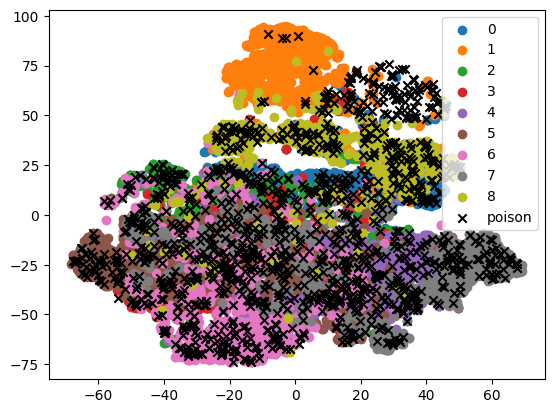

Epoch [61/300]	
	Step [0/391]	 Loss: 3.62053
	Step [50/391]	 Loss: 3.61864
	Step [100/391]	 Loss: 3.6136
	Step [150/391]	 Loss: 3.61823
	Step [200/391]	 Loss: 3.62435
	Step [250/391]	 Loss: 3.61439
	Step [300/391]	 Loss: 3.62211
	Step [350/391]	 Loss: 3.61679

	Training Loss: 3.6158730861780892
	Time Taken: 3.8566943645477294 minutes
Epoch [62/300]	
	Step [0/391]	 Loss: 3.61509
	Step [50/391]	 Loss: 3.62243
	Step [100/391]	 Loss: 3.6268
	Step [150/391]	 Loss: 3.61975
	Step [200/391]	 Loss: 3.61023
	Step [250/391]	 Loss: 3.6156
	Step [300/391]	 Loss: 3.61912
	Step [350/391]	 Loss: 3.61827

	Training Loss: 3.6153257826100225
	Time Taken: 3.849178063869476 minutes
Epoch [63/300]	
	Step [0/391]	 Loss: 3.61313
	Step [50/391]	 Loss: 3.61208
	Step [100/391]	 Loss: 3.62218
	Step [150/391]	 Loss: 3.61483
	Step [200/391]	 Loss: 3.61513
	Step [250/391]	 Loss: 3.61358
	Step [300/391]	 Loss: 3.62063
	Step [350/391]	 Loss: 3.61592

	Training Loss: 3.6148683128454495
	Time Taken: 3.8573113719622296 m

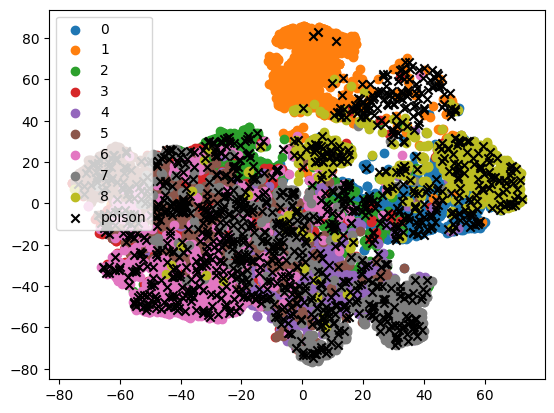

Epoch [71/300]	
	Step [0/391]	 Loss: 3.61454
	Step [50/391]	 Loss: 3.61235
	Step [100/391]	 Loss: 3.61371
	Step [150/391]	 Loss: 3.61056
	Step [200/391]	 Loss: 3.61526
	Step [250/391]	 Loss: 3.61556
	Step [300/391]	 Loss: 3.61144
	Step [350/391]	 Loss: 3.60954

	Training Loss: 3.6124147856631854
	Time Taken: 3.8496275782585143 minutes
Epoch [72/300]	
	Step [0/391]	 Loss: 3.61921
	Step [50/391]	 Loss: 3.60708
	Step [100/391]	 Loss: 3.61033
	Step [150/391]	 Loss: 3.61719
	Step [200/391]	 Loss: 3.61113
	Step [250/391]	 Loss: 3.61226
	Step [300/391]	 Loss: 3.61707
	Step [350/391]	 Loss: 3.61065

	Training Loss: 3.6120962871005164
	Time Taken: 3.84822807709376 minutes
Epoch [73/300]	
	Step [0/391]	 Loss: 3.61448
	Step [50/391]	 Loss: 3.61403
	Step [100/391]	 Loss: 3.61575
	Step [150/391]	 Loss: 3.61507
	Step [200/391]	 Loss: 3.60873
	Step [250/391]	 Loss: 3.61822
	Step [300/391]	 Loss: 3.60915
	Step [350/391]	 Loss: 3.6076

	Training Loss: 3.611689802935666
	Time Taken: 3.8594279448191324 m

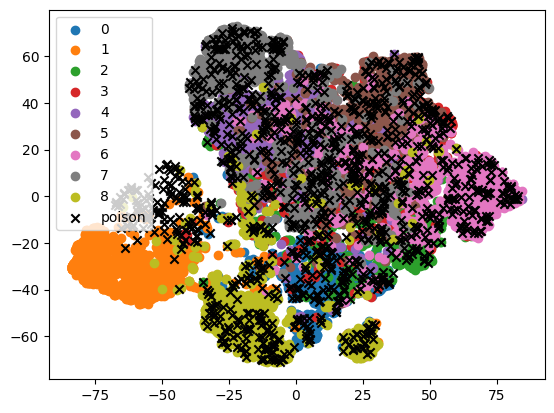

Epoch [81/300]	
	Step [0/391]	 Loss: 3.60716
	Step [50/391]	 Loss: 3.60486
	Step [100/391]	 Loss: 3.60979
	Step [150/391]	 Loss: 3.60776
	Step [200/391]	 Loss: 3.60972
	Step [250/391]	 Loss: 3.61271
	Step [300/391]	 Loss: 3.60709
	Step [350/391]	 Loss: 3.60952

	Training Loss: 3.609380880585107
	Time Taken: 3.8593287825584413 minutes
Epoch [82/300]	
	Step [0/391]	 Loss: 3.60554
	Step [50/391]	 Loss: 3.61326
	Step [100/391]	 Loss: 3.60826
	Step [150/391]	 Loss: 3.61003
	Step [200/391]	 Loss: 3.61645
	Step [250/391]	 Loss: 3.61484
	Step [300/391]	 Loss: 3.60664
	Step [350/391]	 Loss: 3.61011

	Training Loss: 3.6096330060983255
	Time Taken: 3.8524954835573832 minutes
Epoch [83/300]	
	Step [0/391]	 Loss: 3.60362
	Step [50/391]	 Loss: 3.60803
	Step [100/391]	 Loss: 3.61061
	Step [150/391]	 Loss: 3.61768
	Step [200/391]	 Loss: 3.61158
	Step [250/391]	 Loss: 3.60532
	Step [300/391]	 Loss: 3.61095
	Step [350/391]	 Loss: 3.60681

	Training Loss: 3.608761438628292
	Time Taken: 3.881142246723175 

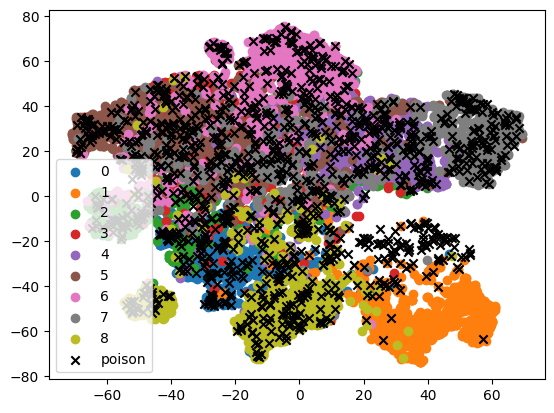

Epoch [91/300]	
	Step [0/391]	 Loss: 3.61335
	Step [50/391]	 Loss: 3.61108
	Step [100/391]	 Loss: 3.60762
	Step [150/391]	 Loss: 3.60223
	Step [200/391]	 Loss: 3.60916
	Step [250/391]	 Loss: 3.60723
	Step [300/391]	 Loss: 3.60681
	Step [350/391]	 Loss: 3.60816

	Training Loss: 3.6072601948857614
	Time Taken: 3.902794388930003 minutes
Epoch [92/300]	
	Step [0/391]	 Loss: 3.60192
	Step [50/391]	 Loss: 3.60935
	Step [100/391]	 Loss: 3.60949
	Step [150/391]	 Loss: 3.60972
	Step [200/391]	 Loss: 3.61047
	Step [250/391]	 Loss: 3.60632
	Step [300/391]	 Loss: 3.60809
	Step [350/391]	 Loss: 3.61219

	Training Loss: 3.6071766038684894
	Time Taken: 3.898144463698069 minutes
Epoch [93/300]	
	Step [0/391]	 Loss: 3.60167
	Step [50/391]	 Loss: 3.60494
	Step [100/391]	 Loss: 3.60542
	Step [150/391]	 Loss: 3.60517
	Step [200/391]	 Loss: 3.6125
	Step [250/391]	 Loss: 3.60608
	Step [300/391]	 Loss: 3.60338
	Step [350/391]	 Loss: 3.60941

	Training Loss: 3.6067825382018026
	Time Taken: 3.8851280649503073 

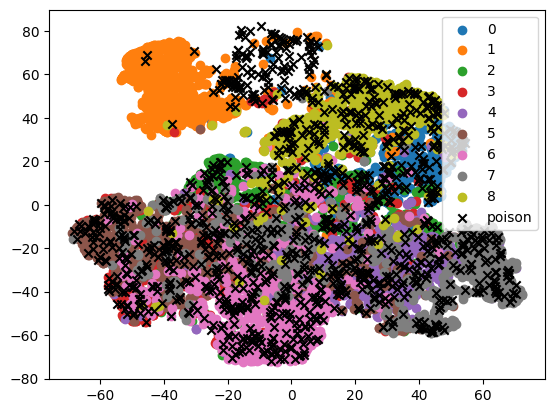

Epoch [101/300]	
	Step [0/391]	 Loss: 3.60556
	Step [50/391]	 Loss: 3.60811
	Step [100/391]	 Loss: 3.61129
	Step [150/391]	 Loss: 3.61639
	Step [200/391]	 Loss: 3.59984
	Step [250/391]	 Loss: 3.61025
	Step [300/391]	 Loss: 3.59872
	Step [350/391]	 Loss: 3.60632

	Training Loss: 3.6050794295337805
	Time Taken: 3.8945618748664854 minutes
Epoch [102/300]	
	Step [0/391]	 Loss: 3.60181
	Step [50/391]	 Loss: 3.60324
	Step [100/391]	 Loss: 3.60262
	Step [150/391]	 Loss: 3.59972
	Step [200/391]	 Loss: 3.60692
	Step [250/391]	 Loss: 3.61048
	Step [300/391]	 Loss: 3.6072
	Step [350/391]	 Loss: 3.60732

	Training Loss: 3.6049801900868528
	Time Taken: 3.894328546524048 minutes
Epoch [103/300]	
	Step [0/391]	 Loss: 3.60121
	Step [50/391]	 Loss: 3.60064
	Step [100/391]	 Loss: 3.60295
	Step [150/391]	 Loss: 3.60809
	Step [200/391]	 Loss: 3.60438
	Step [250/391]	 Loss: 3.60662
	Step [300/391]	 Loss: 3.6092
	Step [350/391]	 Loss: 3.6028

	Training Loss: 3.6048899843259847
	Time Taken: 3.880362002054850

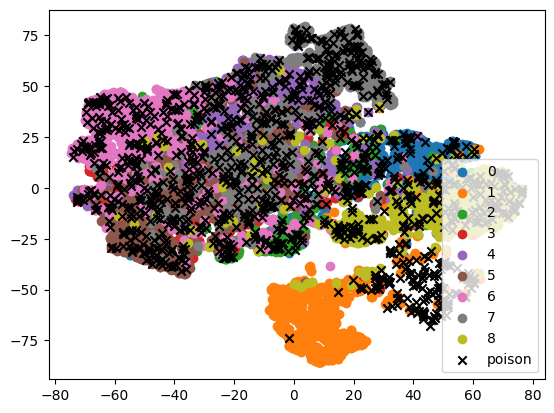

Epoch [111/300]	
	Step [0/391]	 Loss: 3.60341
	Step [50/391]	 Loss: 3.6065
	Step [100/391]	 Loss: 3.60128
	Step [150/391]	 Loss: 3.60511
	Step [200/391]	 Loss: 3.60847
	Step [250/391]	 Loss: 3.60253
	Step [300/391]	 Loss: 3.60258
	Step [350/391]	 Loss: 3.60941

	Training Loss: 3.603298577506219
	Time Taken: 3.9052651802698772 minutes
Epoch [112/300]	
	Step [0/391]	 Loss: 3.61038
	Step [50/391]	 Loss: 3.60386
	Step [100/391]	 Loss: 3.6053
	Step [150/391]	 Loss: 3.60447
	Step [200/391]	 Loss: 3.60274
	Step [250/391]	 Loss: 3.60079
	Step [300/391]	 Loss: 3.60571
	Step [350/391]	 Loss: 3.60169

	Training Loss: 3.6028035205343496
	Time Taken: 3.9104320724805195 minutes
Epoch [113/300]	
	Step [0/391]	 Loss: 3.60142
	Step [50/391]	 Loss: 3.60332
	Step [100/391]	 Loss: 3.59898
	Step [150/391]	 Loss: 3.59921
	Step [200/391]	 Loss: 3.60187
	Step [250/391]	 Loss: 3.602
	Step [300/391]	 Loss: 3.60305
	Step [350/391]	 Loss: 3.60348

	Training Loss: 3.602869726507865
	Time Taken: 3.8846335490544637 

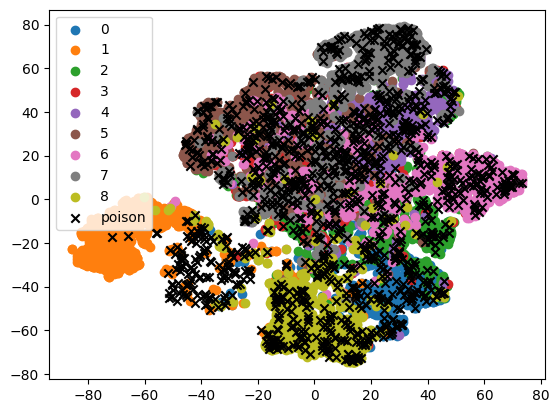

Epoch [121/300]	
	Step [0/391]	 Loss: 3.60177
	Step [50/391]	 Loss: 3.60024
	Step [100/391]	 Loss: 3.6025
	Step [150/391]	 Loss: 3.61357
	Step [200/391]	 Loss: 3.60385
	Step [250/391]	 Loss: 3.60033
	Step [300/391]	 Loss: 3.59511
	Step [350/391]	 Loss: 3.6043

	Training Loss: 3.6011319678762685
	Time Taken: 3.9007142027219137 minutes
Epoch [122/300]	
	Step [0/391]	 Loss: 3.60087
	Step [50/391]	 Loss: 3.60016
	Step [100/391]	 Loss: 3.60046
	Step [150/391]	 Loss: 3.6053
	Step [200/391]	 Loss: 3.60257
	Step [250/391]	 Loss: 3.60566
	Step [300/391]	 Loss: 3.59809
	Step [350/391]	 Loss: 3.59823

	Training Loss: 3.6011799253771066
	Time Taken: 3.9125805060068766 minutes
Epoch [123/300]	
	Step [0/391]	 Loss: 3.60174
	Step [50/391]	 Loss: 3.59845
	Step [100/391]	 Loss: 3.60345
	Step [150/391]	 Loss: 3.60195
	Step [200/391]	 Loss: 3.60028
	Step [250/391]	 Loss: 3.6039
	Step [300/391]	 Loss: 3.60599
	Step [350/391]	 Loss: 3.60024

	Training Loss: 3.6008877522500273
	Time Taken: 3.892567229270935

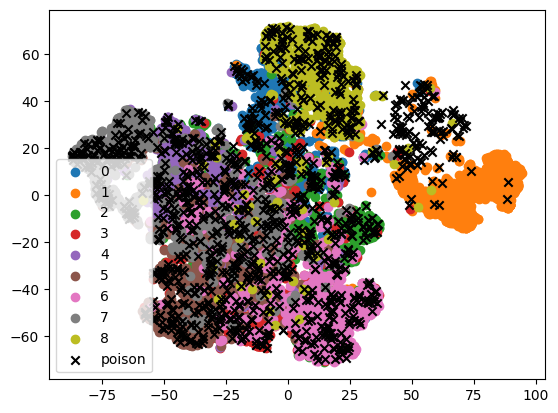

Epoch [131/300]	
	Step [0/391]	 Loss: 3.60046
	Step [50/391]	 Loss: 3.59967
	Step [100/391]	 Loss: 3.59375
	Step [150/391]	 Loss: 3.60382
	Step [200/391]	 Loss: 3.60064
	Step [250/391]	 Loss: 3.5969
	Step [300/391]	 Loss: 3.60322
	Step [350/391]	 Loss: 3.59598

	Training Loss: 3.59993851581193
	Time Taken: 3.8983479142189026 minutes
Epoch [132/300]	
	Step [0/391]	 Loss: 3.6002
	Step [50/391]	 Loss: 3.60035
	Step [100/391]	 Loss: 3.60068
	Step [150/391]	 Loss: 3.59573
	Step [200/391]	 Loss: 3.60394
	Step [250/391]	 Loss: 3.60035
	Step [300/391]	 Loss: 3.59874
	Step [350/391]	 Loss: 3.60232

	Training Loss: 3.599937149935671
	Time Taken: 3.9023386081059774 minutes
Epoch [133/300]	
	Step [0/391]	 Loss: 3.60112
	Step [50/391]	 Loss: 3.60138
	Step [100/391]	 Loss: 3.59749
	Step [150/391]	 Loss: 3.59988
	Step [200/391]	 Loss: 3.59586
	Step [250/391]	 Loss: 3.60402
	Step [300/391]	 Loss: 3.60169
	Step [350/391]	 Loss: 3.5989

	Training Loss: 3.5995282602432135
	Time Taken: 3.8915462096532187 

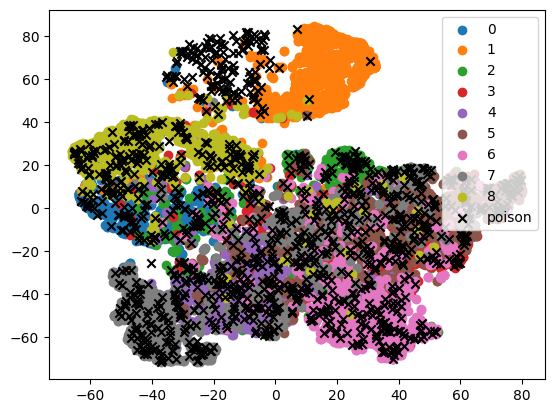

Epoch [141/300]	
	Step [0/391]	 Loss: 3.59771
	Step [50/391]	 Loss: 3.60511
	Step [100/391]	 Loss: 3.59486
	Step [150/391]	 Loss: 3.59351
	Step [200/391]	 Loss: 3.59872
	Step [250/391]	 Loss: 3.60148
	Step [300/391]	 Loss: 3.59823
	Step [350/391]	 Loss: 3.60223

	Training Loss: 3.5988366555070024
	Time Taken: 3.9074134985605875 minutes
Epoch [142/300]	
	Step [0/391]	 Loss: 3.59333
	Step [50/391]	 Loss: 3.60379
	Step [100/391]	 Loss: 3.59563
	Step [150/391]	 Loss: 3.59434
	Step [200/391]	 Loss: 3.59551
	Step [250/391]	 Loss: 3.59661
	Step [300/391]	 Loss: 3.59789
	Step [350/391]	 Loss: 3.5963

	Training Loss: 3.598394111599154
	Time Taken: 3.9132308840751646 minutes
Epoch [143/300]	
	Step [0/391]	 Loss: 3.60531
	Step [50/391]	 Loss: 3.59507
	Step [100/391]	 Loss: 3.60229
	Step [150/391]	 Loss: 3.60151
	Step [200/391]	 Loss: 3.60038
	Step [250/391]	 Loss: 3.59589
	Step [300/391]	 Loss: 3.59796
	Step [350/391]	 Loss: 3.60011

	Training Loss: 3.598387719420216
	Time Taken: 3.89043119351069

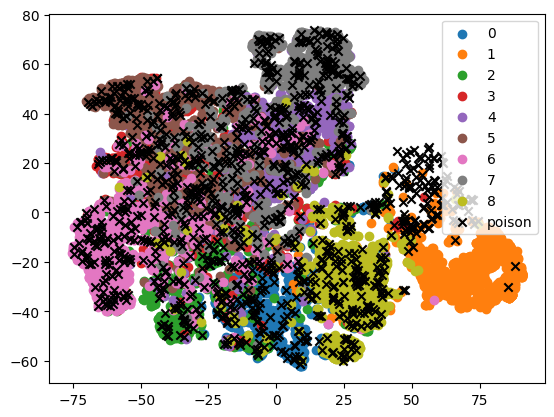

Epoch [151/300]	
	Step [0/391]	 Loss: 3.59942
	Step [50/391]	 Loss: 3.59935
	Step [100/391]	 Loss: 3.60004
	Step [150/391]	 Loss: 3.59771
	Step [200/391]	 Loss: 3.59691
	Step [250/391]	 Loss: 3.60084
	Step [300/391]	 Loss: 3.59872
	Step [350/391]	 Loss: 3.59988

	Training Loss: 3.597328918364347
	Time Taken: 3.900957469145457 minutes
Epoch [152/300]	
	Step [0/391]	 Loss: 3.5944
	Step [50/391]	 Loss: 3.59929
	Step [100/391]	 Loss: 3.60112
	Step [150/391]	 Loss: 3.59669
	Step [200/391]	 Loss: 3.59887
	Step [250/391]	 Loss: 3.60343
	Step [300/391]	 Loss: 3.59654
	Step [350/391]	 Loss: 3.59962

	Training Loss: 3.5969392308188826
	Time Taken: 3.9001408497492474 minutes
Epoch [153/300]	
	Step [0/391]	 Loss: 3.59688
	Step [50/391]	 Loss: 3.60016
	Step [100/391]	 Loss: 3.59844
	Step [150/391]	 Loss: 3.59525
	Step [200/391]	 Loss: 3.59363
	Step [250/391]	 Loss: 3.59835
	Step [300/391]	 Loss: 3.59618
	Step [350/391]	 Loss: 3.59886

	Training Loss: 3.5968053438474454
	Time Taken: 3.89070758819580

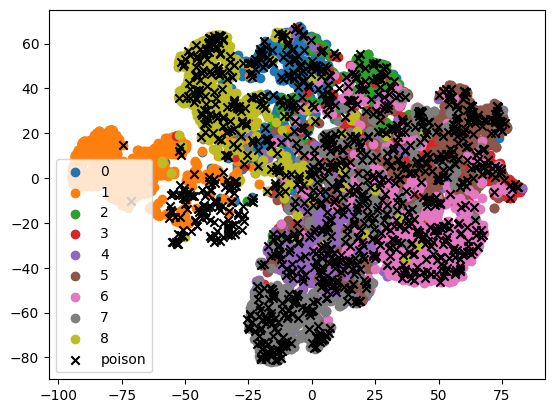

Epoch [161/300]	
	Step [0/391]	 Loss: 3.59301
	Step [50/391]	 Loss: 3.60061
	Step [100/391]	 Loss: 3.60019
	Step [150/391]	 Loss: 3.60312
	Step [200/391]	 Loss: 3.59829
	Step [250/391]	 Loss: 3.59692
	Step [300/391]	 Loss: 3.59879
	Step [350/391]	 Loss: 3.60257

	Training Loss: 3.5958975410217517
	Time Taken: 3.8719284971555075 minutes
Epoch [162/300]	
	Step [0/391]	 Loss: 3.59911
	Step [50/391]	 Loss: 3.5926
	Step [100/391]	 Loss: 3.59781
	Step [150/391]	 Loss: 3.59344
	Step [200/391]	 Loss: 3.59453
	Step [250/391]	 Loss: 3.59692
	Step [300/391]	 Loss: 3.59978
	Step [350/391]	 Loss: 3.59663

	Training Loss: 3.5959957475247593
	Time Taken: 4.494448490937551 minutes
Epoch [163/300]	
	Step [0/391]	 Loss: 3.59753
	Step [50/391]	 Loss: 3.59862


KeyboardInterrupt: 

In [20]:
losses = []

for epoch in range(start_epoch, epochs+1):
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    loss = train(dataloader, model, criterion, optimizer)
    losses.append(loss)

    if epoch <= 10:
        warmupscheduler.step()
    if epoch > 10:
        mainscheduler.step()
    
    print()
    print(f"\tTraining Loss: {loss}")
    time_taken = (time.time()-stime)/60
    print(f"\tTime Taken: {time_taken} minutes")

    if (epoch) % 10 == 0:
        save_model(model, optimizer, mainscheduler, epoch, f"SimCLR_{epoch}.pt")
        plot_features(model, dataloader_no_contrastive, 100)

## end training
save_model(model, optimizer, mainscheduler, epochs, f"SimCLR_{epochs}.pt")